# Bug Classification with BugNIST2D dataset

In [1]:
import os
from skimage import io
import pickle
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.ndimage
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score


(64, 32, 3)
uint8
255
0


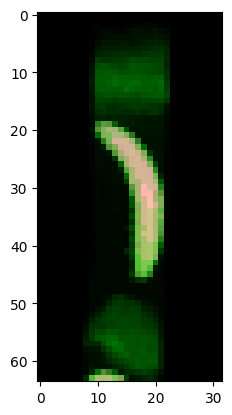

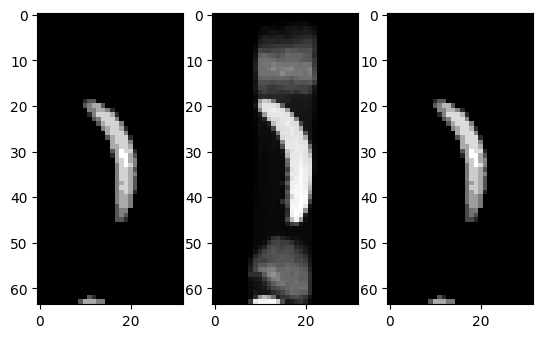

(64, 32)


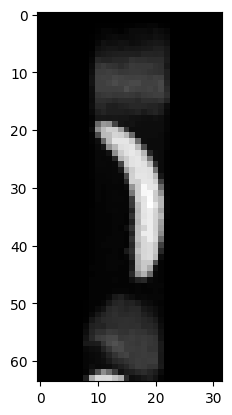

In [2]:
# Visualize the data
folder = "./data/week9_BugNIST2D_train/train/"
filename = 'bug_00000.png'
img = io.imread(os.path.join(folder, filename))
print(img.shape)
# see image type
print(img.dtype)
print(img.max())
print(img.min())
plt.figure()
plt.imshow(img, cmap='gray')

# see 3 channels of the image
plt.figure()
plt.subplot(131)
plt.imshow(img[:,:,0], cmap='gray')
plt.subplot(132)
plt.imshow(img[:,:,1], cmap='gray')
plt.subplot(133)
plt.imshow(img[:,:,2], cmap='gray')
plt.show()

# Convert to grayscale using OpenCV
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
print(img_gray.shape)  # Should be (height, width)
plt.imshow(img_gray, cmap='gray')
plt.show()


In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in sorted(os.listdir(folder)):
        img = io.imread(os.path.join(folder, filename))
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img_gray = img_gray / 255.0  # Normalize pixel values to [0, 1]
        images.append(img_gray)

    return np.array(images)

# Load images from the folder
X_images = load_images_from_folder(folder)
print(X_images.shape)  # Should be (num_images, height, width)

(28000, 64, 32)


In [4]:
def one_hot_encode(targets, num_classes=None):
    """
    One-hot encode the target values.

    Args:
        targets (numpy.ndarray): Array of target values (integers).
        num_classes (int): Total number of classes. If None, inferred from the targets.

    Returns:
        numpy.ndarray: One-hot encoded matrix of shape (num_samples, num_classes).
    """
    if num_classes is None:
        num_classes = np.max(targets) + 1  # Infer number of classes from the targets
    one_hot = np.zeros((len(targets), num_classes))
    one_hot[np.arange(len(targets)), targets] = 1
    return one_hot

# Path to the train_targets.txt file
targets_file = "./data/week9_BugNIST2D_train/train_targets.txt"

# Read the targets
targets = np.loadtxt(targets_file, dtype=int)  # Assuming the targets are integers
print("Targets:", targets)
print(f"Number of targets: {len(targets)}")

# One-hot encode the targets
one_hot_targets = one_hot_encode(targets)
print("One-hot encoded targets:")
print(one_hot_targets)
print(f"Shape of one-hot encoded targets: {one_hot_targets.shape}")

Targets: [ 3 10  1 ... 11  9 10]
Number of targets: 28000
One-hot encoded targets:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
Shape of one-hot encoded targets: (28000, 12)


In [5]:
def resize_images_to_vectors(images):
    num_images, height, width = images.shape
    return images.reshape(num_images, height * width)

# Resize images to vectors
X_vectors = resize_images_to_vectors(X_images)
print(f"Original shape: {X_images.shape}")
print(f"Resized shape: {X_vectors.shape}")

Original shape: (28000, 64, 32)
Resized shape: (28000, 2048)


In [6]:
# Split the dataset into training and testing sets
X_train_full, X_test, T_train_full, T_test = train_test_split(
    X_vectors, one_hot_targets, test_size=0.2, random_state=42
)

# Further split the training set into training and validation sets
X_train, X_val, T_train, T_val = train_test_split(
    X_train_full, T_train_full, test_size=0.25, random_state=42
)  # 0.15 x 0.8 = 0.12 (12% of the original dataset for validation)

# Transpose back to original shape
X_train = X_train.T
X_val = X_val.T
X_test = X_test.T
T_train = T_train.T
T_val = T_val.T
T_test = T_test.T

# Print shapes of the splits
print("Training data shape:", X_train.shape)
print("Training labels shape:", T_train.shape)
print("Validation data shape:", X_val.shape)
print("Validation labels shape:", T_val.shape)
print("Testing data shape:", X_test.shape)
print("Testing labels shape:", T_test.shape)

Training data shape: (2048, 16800)
Training labels shape: (12, 16800)
Validation data shape: (2048, 5600)
Validation labels shape: (12, 5600)
Testing data shape: (2048, 5600)
Testing labels shape: (12, 5600)


In [7]:
def augment_image(image):
    # Random horizontal flip
    if np.random.rand() > 0.8:
        image = np.fliplr(image)

    # Random rotation
    if np.random.rand() > 0.8:
        angle = np.random.uniform(-15, 15)
        image = scipy.ndimage.rotate(image, angle, reshape=False, mode='nearest')

    # Random shift
    if np.random.rand() > 0.8:
        shift = np.random.randint(-3, 4, 2)  # up to 3 pixels in each direction
        image = scipy.ndimage.shift(image, shift, mode='nearest')

    return image

In [8]:
# Convert back to original shape: (num_samples, H, W)
X_train_original = X_train.T.reshape(-1, 64, 32)
T_train_original = T_train.T  # shape: (num_samples, num_classes)

augmented_images = []
augmented_targets = []

# Create 2 augmented versions per image
for img, label in zip(X_train_original, T_train_original):
    for _ in range(2):  # Number of augmentations per image
        augmented = augment_image(img)
        augmented_images.append(augmented)
        augmented_targets.append(label)

# Combine original and augmented
X_train_augmented = np.concatenate([X_train_original, np.array(augmented_images)])
T_train_augmented = np.concatenate([T_train_original, np.array(augmented_targets)])

print(f"Original training images: {T_train_original.shape[0]}")
print(f"Augmented training images: {T_train_augmented.shape[0]}")

Original training images: 16800
Augmented training images: 50400


In [9]:
# Resize images to vectors
X_train_aug = resize_images_to_vectors(X_train_augmented)
X_train_aug = X_train_aug.T
T_train_aug = T_train_augmented.T
print(f"Original shape: {X_train_augmented.shape}")
print(f"Resized shape: {X_train_aug.shape}")

print(f"Original shape: {T_train_augmented.shape}")
print(f"Resized shape: {T_train_aug.shape}")

Original shape: (50400, 64, 32)
Resized shape: (2048, 50400)
Original shape: (50400, 12)
Resized shape: (12, 50400)


In [10]:
def forward_pass_dynamic(X, weights):
    """
    Perform a forward pass through a neural network with multiple layers.

    Args:
        X (numpy.ndarray): Input data of shape (input_dim, num_samples).
        weights (list): List of weight matrices for each layer.

    Returns:
        activations (list): List of activations for each layer (including input and hidden layers).
        outputs (numpy.ndarray): Output of the network after softmax activation.
    """
    activations = [np.vstack((X, np.ones((1, X.shape[1]))))]  # Add bias to input and store as the first activation
    for W in weights[:-1]:  # For all layers except the output layer
        z = np.dot(W.T, activations[-1])  # Compute z = W * activations of the previous layer
        h = np.maximum(z, 0)  # Apply ReLU activation
        h = np.vstack((h, np.ones((1, h.shape[1]))))  # Add bias
        activations.append(h)  # Store activations for this layer

    # Output layer
    z = np.dot(weights[-1].T, activations[-1])  # Compute z for the output layer
    e_x = np.exp(z - np.max(z, axis=0))  # Apply softmax activation
    outputs = e_x / e_x.sum(axis=0)  # Normalize to get probabilities
    
    return activations, outputs


In [11]:
def backward_pass_dynamic(X, T, weights, activations, outputs, lr=0.001):
    """
    Perform the backward pass and update the weights of a dynamic neural network.

    Args:
        X (np.ndarray): Input data of shape (input_dim, num_samples).
        T (np.ndarray): One-hot encoded target labels of shape (output_dim, num_samples).
        weights (list): List of weight matrices for each layer (to be updated in-place).
        activations (list): List of activations from the forward pass (including bias units).
        outputs (np.ndarray): Output of the network from the forward pass (after softmax).
        lr (float): Learning rate.

    Returns:
        None. The weights are updated in-place.
    """
    delta = outputs - T  # Output layer error
    grad = np.dot(activations[-1], delta.T) / X.shape[1]  # Gradient for output layer
    weights[-1] -= lr * grad  # Update output weights

    # Backpropagate through hidden layers
    for i in range(len(weights) - 2, -1, -1):
        W_no_bias = weights[i + 1][:-1, :]
        h_no_bias = activations[i + 1][:-1, :]
        relu_derivative = h_no_bias > 0

        delta = np.dot(W_no_bias, delta) * relu_derivative  # Compute delta for current layer
        grad = np.dot(activations[i], delta.T) / X.shape[1]  # Compute gradient
        weights[i] -= lr * grad  # Update weights

    return weights  # Return updated weights for verification (optional)

In [12]:
def cross_entropy_loss(y, t):
    """
    Compute cross-entropy loss.
    
    Args:
        y (np.ndarray): Predicted probabilities, shape (num_classes, num_samples)
        t (np.ndarray): One-hot true labels, shape (num_classes, num_samples)
    
    Returns:
        float: Average cross-entropy loss
    """
    eps = 1e-10  # to avoid log(0)
    return -np.sum(t * np.log(y + eps)) / y.shape[1]

In [13]:
def batch_optimization_dynamic3(X_train, T_train, X_val, T_val, weights, lr, batch_size, epochs):
    """
    Perform batch optimization and track training and validation error.

    Args:
        X_train (np.ndarray): Training input data.
        T_train (np.ndarray): Training target labels.
        X_val (np.ndarray): Validation input data.
        T_val (np.ndarray): Validation target labels.
        weights (list): Initial weights of the network.
        lr (float): Learning rate.
        batch_size (int): Size of mini-batches.
        epochs (int): Number of epochs to train.

    Returns:
        weights (list): Updated weights for each layer.
    """
    num_samples = X_train.shape[1]
    train_errors = []
    val_errors = []

    for epoch in range(epochs):
        indices = np.random.permutation(num_samples)
        X_train_shuffled = X_train[:, indices]
        T_train_shuffled = T_train[:, indices]

        for i in range(0, num_samples, batch_size):
            X_batch = X_train_shuffled[:, i:i + batch_size]
            T_batch = T_train_shuffled[:, i:i + batch_size]

            activations, outputs = forward_pass_dynamic(X_batch, weights)
            backward_pass_dynamic(X_batch, T_batch, weights, activations, outputs, lr)

        # Training loss
        _, train_outputs = forward_pass_dynamic(X_train, weights)
        train_loss = cross_entropy_loss(train_outputs, T_train)
        train_errors.append(train_loss)

        # Validation loss
        _, val_outputs = forward_pass_dynamic(X_val, weights)
        val_loss = cross_entropy_loss(val_outputs, T_val)
        val_errors.append(val_loss)

        print(f"Epoch {epoch + 1}/{epochs} - Training loss: {train_loss:.4f} | Validation loss: {val_loss:.4f}")

    # Plotting
    plt.plot(train_errors, label='Training loss')
    plt.plot(val_errors, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Cross-Entropy Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

    return weights


In [14]:
def initialize_weights_dynamic(architecture):
    """
    Initialize weights for a neural network with a variable number of layers.

    Args:
        architecture (list): List specifying the number of units in each layer.

    Returns:
        weights (list): List of weight matrices for each layer.
    """
    weights = []
    for i in range(len(architecture) - 1):
        # Initialize weights with He initialization
        input_units = architecture[i]
        output_units = architecture[i + 1]
        W = np.random.normal(0, 1, (input_units + 1, output_units)) * np.sqrt(2 / (input_units + 1))
        weights.append(W)
        
    return weights

Epoch 1/80 - Training loss: 2.2947 | Validation loss: 2.2822
Epoch 2/80 - Training loss: 1.9716 | Validation loss: 1.9522
Epoch 3/80 - Training loss: 1.6787 | Validation loss: 1.6464
Epoch 4/80 - Training loss: 1.4518 | Validation loss: 1.4103
Epoch 5/80 - Training loss: 1.2894 | Validation loss: 1.2403
Epoch 6/80 - Training loss: 1.1675 | Validation loss: 1.1153
Epoch 7/80 - Training loss: 1.0778 | Validation loss: 1.0254
Epoch 8/80 - Training loss: 1.0120 | Validation loss: 0.9562
Epoch 9/80 - Training loss: 0.9633 | Validation loss: 0.9102
Epoch 10/80 - Training loss: 0.9254 | Validation loss: 0.8681
Epoch 11/80 - Training loss: 0.8945 | Validation loss: 0.8440
Epoch 12/80 - Training loss: 0.8648 | Validation loss: 0.8120
Epoch 13/80 - Training loss: 0.8418 | Validation loss: 0.7875
Epoch 14/80 - Training loss: 0.8245 | Validation loss: 0.7714
Epoch 15/80 - Training loss: 0.8035 | Validation loss: 0.7522
Epoch 16/80 - Training loss: 0.7922 | Validation loss: 0.7462
Epoch 17/80 - Tra

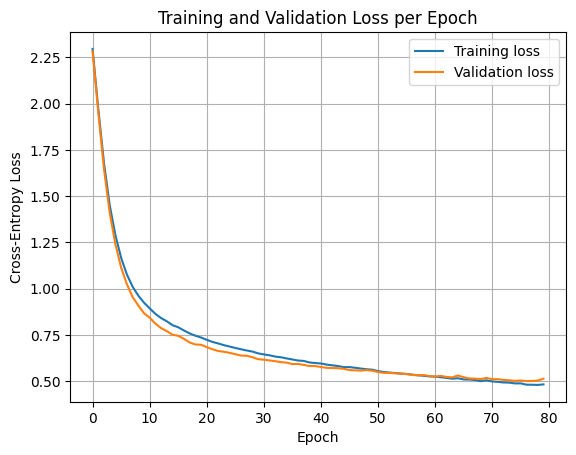

Accuracy: 81.79%


In [15]:
# Define architecture
# architecture = [X_train_digits.shape[0], 4, 8, 10, 8, 4, T_train_digits.shape[0]]  # 2 input features, 2 hidden layers, 2 output classes
architecture = [X_train.shape[0], 28, 28, 28, T_train.shape[0]]
#architecture = [X_train.shape[1], 128, 64, T_train.shape[1]]

# Initialize weights
weights = initialize_weights_dynamic(architecture)

# Train the network
weights = batch_optimization_dynamic3(X_train_aug, T_train_aug, X_val, T_val, weights, lr=0.001, batch_size=32, epochs=80)

# Test the network
_, y_test = forward_pass_dynamic(X_test, weights)

# Compute predictions
predicted_classes = np.argmax(y_test, axis=0)
real_classes = np.argmax(T_test, axis=0)
accuracy = np.mean(predicted_classes == real_classes)
print(f"Accuracy: {accuracy * 100:.2f}%")

In [16]:
def plot_confusion_matrix(X, T, weights, class_names=None, title="Confusion Matrix"):
    """
    Plot the confusion matrix and compute accuracy for a classifier.

    Args:
        X (np.ndarray): Input data, shape (input_dim, num_samples).
        T (np.ndarray): True labels (one-hot), shape (num_classes, num_samples).
        weights (list): Trained weights of the model.
        class_names (list): Optional, list of class names.
        title (str): Title for the plot.
    """
    # Forward pass to get predictions
    _, outputs = forward_pass_dynamic(X, weights)
    y_pred = np.argmax(outputs, axis=0)
    y_true = np.argmax(T, axis=0)

    # Compute confusion matrix and accuracy
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc * 100:.2f}%")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"{title}\nAccuracy: {acc * 100:.2f}%")
    plt.tight_layout()
    plt.show()

Accuracy: 81.79%


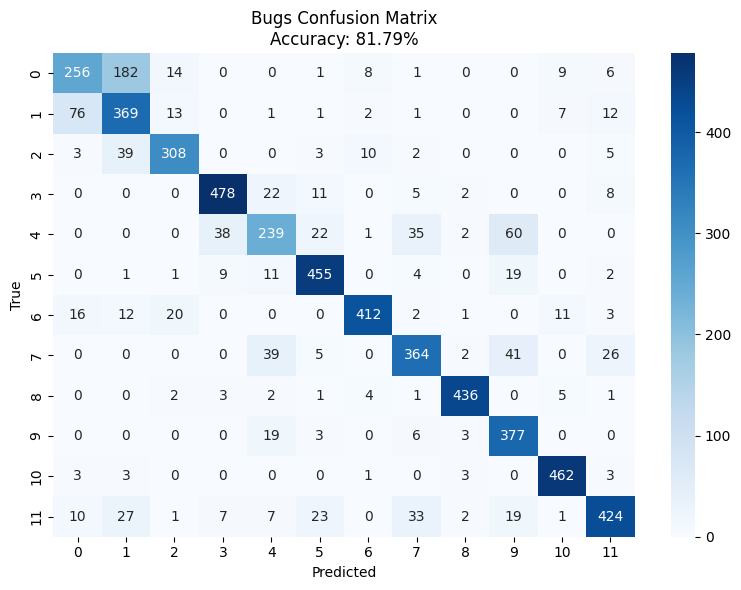

In [17]:
class_names = [str(i) for i in range(12)]
plot_confusion_matrix(X_test, T_test, weights, class_names=class_names, title="Bugs Confusion Matrix")

In [18]:
def save_weights(weights):
    """
    Save the weights to a file using pickle.

    Args:
        weights (list): List of weight matrices to save.
    """
    # Create directory if it doesn't exist
    if not os.path.exists('weights'):
        os.makedirs('weights')

    # Find the next available filename
    i = 0

    # Save weights using pickle
    weights_file = f"weights/weights_{i}.pkl"

    while os.path.exists(weights_file):
        i += 1
        weights_file = f"weights/weights_{i}.pkl"

    with open(weights_file, 'wb') as f:
        pickle.dump(weights, f)
        
    print(f"Weights saved to {weights_file}")

    return weights_file

Weights saved to weights/weights_0.pkl
Weights loaded successfully
Epoch 1/80 - Training loss: 0.4041 | Validation loss: 0.4951
Epoch 2/80 - Training loss: 0.4047 | Validation loss: 0.4954
Epoch 3/80 - Training loss: 0.3999 | Validation loss: 0.4924
Epoch 4/80 - Training loss: 0.3996 | Validation loss: 0.4919
Epoch 5/80 - Training loss: 0.3991 | Validation loss: 0.4931
Epoch 6/80 - Training loss: 0.3992 | Validation loss: 0.4933
Epoch 7/80 - Training loss: 0.3980 | Validation loss: 0.4947
Epoch 8/80 - Training loss: 0.3968 | Validation loss: 0.4908
Epoch 9/80 - Training loss: 0.3934 | Validation loss: 0.4892
Epoch 10/80 - Training loss: 0.3929 | Validation loss: 0.4885
Epoch 11/80 - Training loss: 0.3938 | Validation loss: 0.4880
Epoch 12/80 - Training loss: 0.3939 | Validation loss: 0.4898
Epoch 13/80 - Training loss: 0.3908 | Validation loss: 0.4890
Epoch 14/80 - Training loss: 0.3893 | Validation loss: 0.4873
Epoch 15/80 - Training loss: 0.3910 | Validation loss: 0.4910
Epoch 16/80 

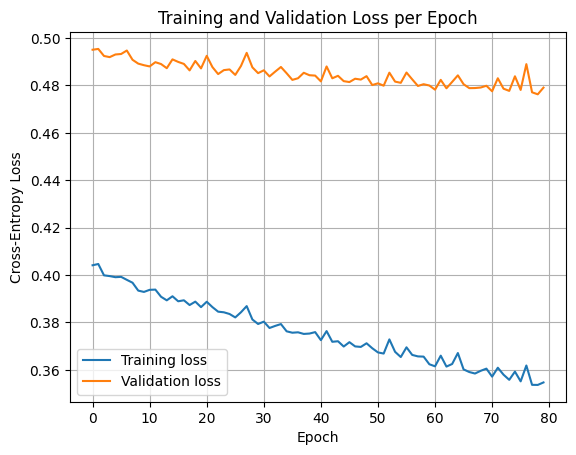

Accuracy after fine-tuning: 82.68%
Accuracy: 82.68%


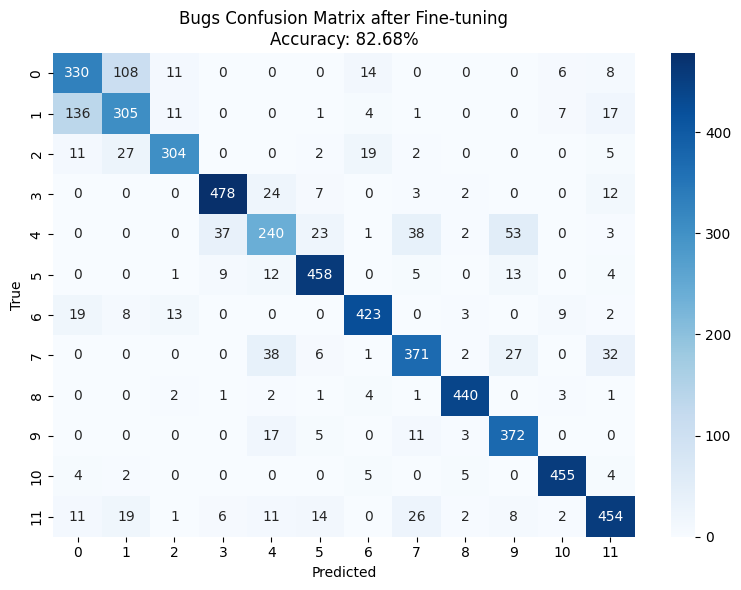

In [19]:
# Fine-tune the model 
weights_file = save_weights(weights)

# Load weights using pickle
with open(weights_file, 'rb') as f:
    weights = pickle.load(f)

print("Weights loaded successfully")

weights_ft = batch_optimization_dynamic3(X_train, T_train, X_val, T_val, weights, lr=0.0005, batch_size=32, epochs=80)

# Test the network again
_, y_test = forward_pass_dynamic(X_test, weights)

# Compute predictions
predicted_classes = np.argmax(y_test, axis=0)
real_classes = np.argmax(T_test, axis=0)
accuracy = np.mean(predicted_classes == real_classes)
print(f"Accuracy after fine-tuning: {accuracy * 100:.2f}%")

#Plot confusion matrix
plot_confusion_matrix(X_test, T_test, weights, class_names=class_names, title="Bugs Confusion Matrix after Fine-tuning")

In [20]:
# Fine-tune again
weights_file = save_weights(weights_ft)

# Load weights using pickle
with open(weights_file, 'rb') as f:
    weights = pickle.load(f)

print("Weights loaded successfully")

Weights saved to weights/weights_1.pkl
Weights loaded successfully


Epoch 1/80 - Training loss: 0.3553 | Validation loss: 0.4803
Epoch 2/80 - Training loss: 0.3620 | Validation loss: 0.4887
Epoch 3/80 - Training loss: 0.3527 | Validation loss: 0.4792
Epoch 4/80 - Training loss: 0.3527 | Validation loss: 0.4805
Epoch 5/80 - Training loss: 0.3528 | Validation loss: 0.4799
Epoch 6/80 - Training loss: 0.3556 | Validation loss: 0.4826
Epoch 7/80 - Training loss: 0.3516 | Validation loss: 0.4789
Epoch 8/80 - Training loss: 0.3526 | Validation loss: 0.4806
Epoch 9/80 - Training loss: 0.3475 | Validation loss: 0.4763
Epoch 10/80 - Training loss: 0.3470 | Validation loss: 0.4750
Epoch 11/80 - Training loss: 0.3474 | Validation loss: 0.4763
Epoch 12/80 - Training loss: 0.3480 | Validation loss: 0.4806
Epoch 13/80 - Training loss: 0.3439 | Validation loss: 0.4762
Epoch 14/80 - Training loss: 0.3465 | Validation loss: 0.4792
Epoch 15/80 - Training loss: 0.3406 | Validation loss: 0.4736
Epoch 16/80 - Training loss: 0.3427 | Validation loss: 0.4769
Epoch 17/80 - Tra

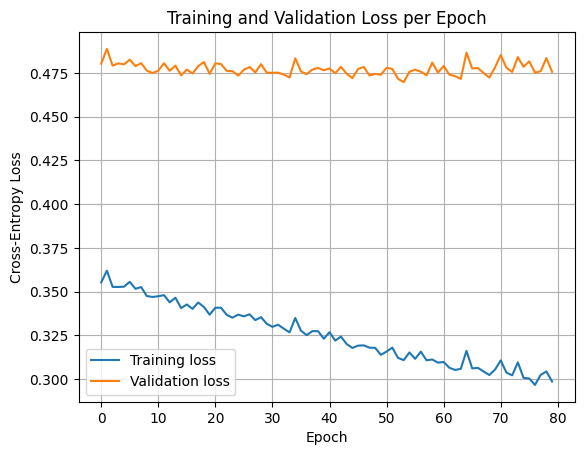

Accuracy after fine-tuning: 83.30%
Accuracy: 83.30%


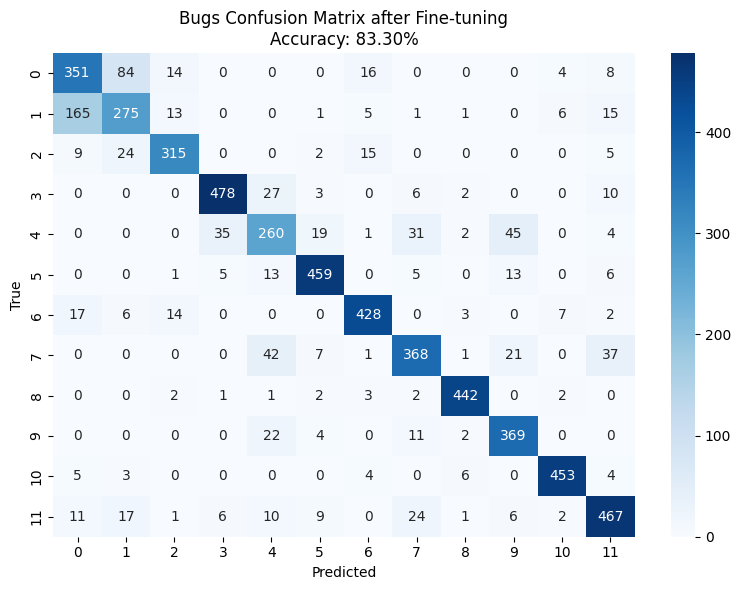

In [21]:
weights_ft_1 = batch_optimization_dynamic3(X_train, T_train, X_val, T_val, weights, lr=0.001, batch_size=32, epochs=80)

# Test the network again
_, y_test = forward_pass_dynamic(X_test, weights)

# Compute predictions
predicted_classes = np.argmax(y_test, axis=0)
real_classes = np.argmax(T_test, axis=0)
accuracy = np.mean(predicted_classes == real_classes)
print(f"Accuracy after fine-tuning: {accuracy * 100:.2f}%")

#Plot confusion matrix
plot_confusion_matrix(X_test, T_test, weights, class_names=class_names, title="Bugs Confusion Matrix after Fine-tuning")

In [22]:
weights_file = save_weights(weights_ft_1)

# Load weights using pickle
with open(weights_file, 'rb') as f:
    weights = pickle.load(f)

Weights saved to weights/weights_2.pkl


Epoch 1/50 - Training loss: 0.2984 | Validation loss: 0.4788
Epoch 2/50 - Training loss: 0.2928 | Validation loss: 0.4753
Epoch 3/50 - Training loss: 0.3009 | Validation loss: 0.4813
Epoch 4/50 - Training loss: 0.2961 | Validation loss: 0.4808
Epoch 5/50 - Training loss: 0.2922 | Validation loss: 0.4777
Epoch 6/50 - Training loss: 0.2933 | Validation loss: 0.4762
Epoch 7/50 - Training loss: 0.2920 | Validation loss: 0.4775
Epoch 8/50 - Training loss: 0.2917 | Validation loss: 0.4786
Epoch 9/50 - Training loss: 0.2903 | Validation loss: 0.4769
Epoch 10/50 - Training loss: 0.2919 | Validation loss: 0.4784
Epoch 11/50 - Training loss: 0.2903 | Validation loss: 0.4743
Epoch 12/50 - Training loss: 0.2937 | Validation loss: 0.4796
Epoch 13/50 - Training loss: 0.2917 | Validation loss: 0.4805
Epoch 14/50 - Training loss: 0.2867 | Validation loss: 0.4743
Epoch 15/50 - Training loss: 0.2962 | Validation loss: 0.4875
Epoch 16/50 - Training loss: 0.2912 | Validation loss: 0.4810
Epoch 17/50 - Tra

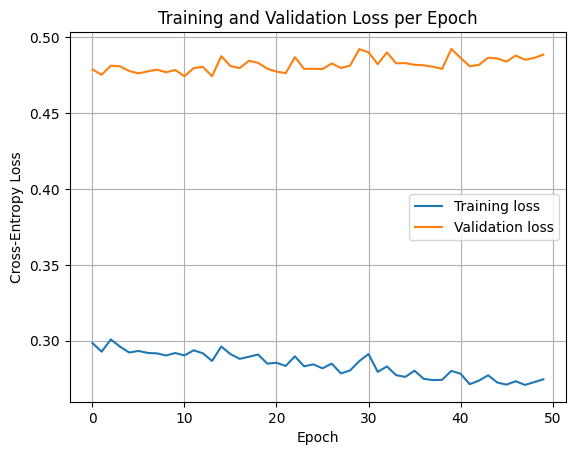

Accuracy after fine-tuning: 83.43%
Accuracy: 83.43%


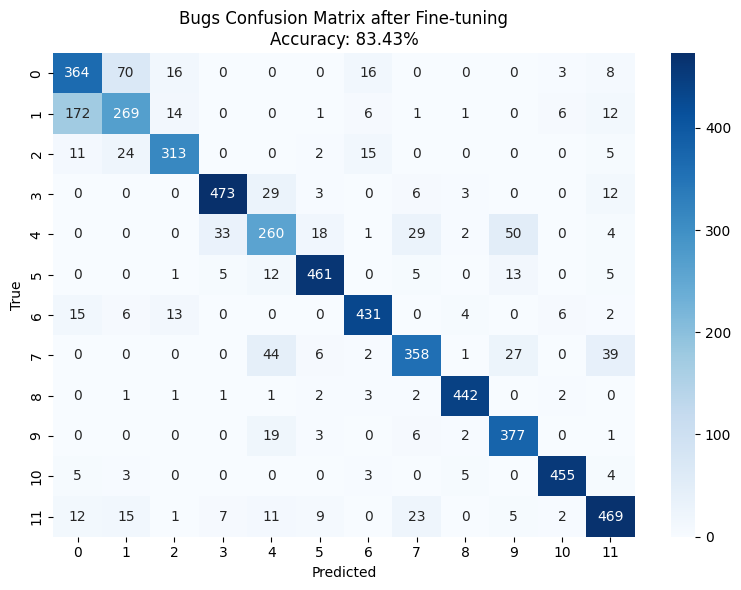

In [23]:
weights_ft_2 = batch_optimization_dynamic3(X_train, T_train, X_val, T_val, weights, lr=0.001, batch_size=32, epochs=50)

# Test the network again
_, y_test = forward_pass_dynamic(X_test, weights)

# Compute predictions
predicted_classes = np.argmax(y_test, axis=0)
real_classes = np.argmax(T_test, axis=0)
accuracy = np.mean(predicted_classes == real_classes)
print(f"Accuracy after fine-tuning: {accuracy * 100:.2f}%")

#Plot confusion matrix
plot_confusion_matrix(X_test, T_test, weights, class_names=class_names, title="Bugs Confusion Matrix after Fine-tuning")

In [24]:
final_weights_file = save_weights(weights_ft_2)

Weights saved to weights/weights_3.pkl
